In [21]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import ExtraTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix

from sklearn.learning_curve import learning_curve

from imblearn.over_sampling import SMOTE


import matplotlib.pyplot as plt
%matplotlib inline

##### Kaggle suggestion:

A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

In [61]:
df = pd.read_csv("adult.csv")
set(df['hours.per.week'])

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 70,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 94,
 95,
 96,
 97,
 98,
 99}

In [23]:
#  Value counts of all features
for col in df.columns:
    print("----------------\n----------------")
    print(col.upper()+":"+"\n")
    print(eval("df[col].value_counts()"))

----------------
----------------
AGE:

36    898
31    888
34    886
23    877
35    876
33    875
28    867
30    861
37    858
25    841
27    835
32    828
38    827
39    816
29    813
41    808
24    798
40    794
26    785
42    780
43    770
22    765
20    753
46    737
45    734
44    724
21    720
19    712
47    708
50    602
     ... 
60    312
61    300
62    258
63    230
64    208
65    178
67    151
66    150
68    120
69    108
70     89
71     72
72     67
73     64
74     51
76     46
75     45
90     43
77     29
78     23
80     22
79     22
81     20
82     12
84     10
83      6
85      3
88      3
87      1
86      1
Name: age, Length: 73, dtype: int64
----------------
----------------
WORKCLASS:

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64
----

In [24]:
#  Sanity check - so workclass ~ occupation is reasonable
len(df[df.workclass == "?"]), len(df[df.occupation == "?"])

(1836, 1843)

In [25]:
#  Do these seem to map properly? Yes.
df[["education", "education.num"]].head(20)

,education,education.num
0,HS-grad,9
1,HS-grad,9
2,Some-college,10
3,7th-8th,4
4,Some-college,10
5,HS-grad,9
6,10th,6
7,Doctorate,16
8,HS-grad,9
9,Some-college,10


In [26]:
#  Will impute ?'s, but drop for now.
df2 = df.replace("?", np.nan)
df2.dropna(how='any', inplace=True)
df2.reset_index(drop=True, inplace=True)

#  I will drop fnlwgt feature b/c it makes no sense.
df2.drop(['fnlwgt'], axis=1, inplace=True)

#  Encode income as 0/1 & replace w/ income
df2['enough_income'] = df2.income.str.contains('>').astype(int)
df2.drop(["income"], axis=1, inplace=True)

In [27]:
#  Checking to see if fnlwgt matters.

df5 = df.replace("?", np.nan)
df5.dropna(how='any', inplace=True)
df5.reset_index(drop=True, inplace=True)

#  Encode income as 0/1 & replace w/ income
df5['enough_income'] = df5.income.str.contains('>').astype(int)
df5.drop(["income"], axis=1, inplace=True)

In [46]:
#  Sanity check.
df2.head()

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,enough_income
0,82,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
1,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
2,41,Private,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0
3,34,Private,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,0
4,38,Private,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,0


In [29]:
y = df2["enough_income"]
X = df2.drop(["enough_income"], axis=1)
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [52]:
#  Testing initial hypothesis
X2 = df2.drop(["enough_income", "workclass", "education", "marital.status", "occupation", "relationship", "race", "capital.gain", "capital.loss", "native.country"], axis=1)
X2.sex = X2.sex.map({"Male": 1, "Female": 0})

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y)

In [57]:
X2.head()

,age,education.num,sex,hours.per.week
0,82,9,0,18
1,54,4,0,40
2,41,10,0,40
3,34,9,0,45
4,38,6,1,40


In [30]:
#  For fnlwgt - delete later

y5 = df5["enough_income"]
X5 = df5.drop(["enough_income"], axis=1)
X5 = pd.get_dummies(X5)

X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y)

In [31]:
scaler = StandardScaler()
X_train_trans = scaler.fit_transform(X_train)
X_test_fitted = scaler.transform(X_test)

In [53]:
#  Testing initial hypothesis

X2_train_trans = scaler.fit_transform(X2_train)
X2_test_fitted = scaler.transform(X2_test)

In [32]:
#  For fnlwgt - delete later

X5_train_trans = scaler.fit_transform(X5_train)
X5_test_fitted = scaler.transform(X5_test)

knn: 0.8728079346570842
logistic: 0.8995447504045624
tree: 0.7579567538578257
forest: 0.8633239807454414
bc: 0.8677100267964257
gbc: 0.9180762819865981
dummy: 0.5014734763970954


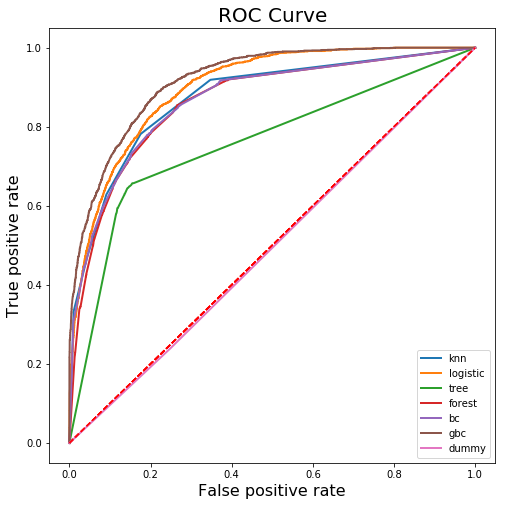

In [33]:
models = [('knn', KNN), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier),
#           ('svm', SVC),  # this one takes SO LONG, TOO LONG
          ('bc', BaggingClassifier),
          ('gbc', GradientBoostingClassifier),
          ('dummy', DummyClassifier)
         ]


#  add in a neural net?

#  ROC w/o normalizing
for model in models:
    plt.rcParams.update({'figure.figsize': (8, 8)})
    my_model = model[1]()
    my_model.fit(X_train, y_train)
    y_preds = my_model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, my_model.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr,lw=2, label=model[0])
    plt.plot([0,1],[0,1],c='r',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate', fontsize=16)
    plt.ylabel('True positive rate', fontsize=16)
    plt.title('ROC Curve', fontsize=20)
    plt.legend()
    print("{}: {}".format(model[0], roc_auc_score(y_test, y_preds)))

knn: 0.8378278544546722
logistic: 0.9016499702884821
tree: 0.7593471688100071
forest: 0.8652033276900135
bc: 0.8717273884136292
gbc: 0.9180355454399359
dummy: 0.5014533884211037


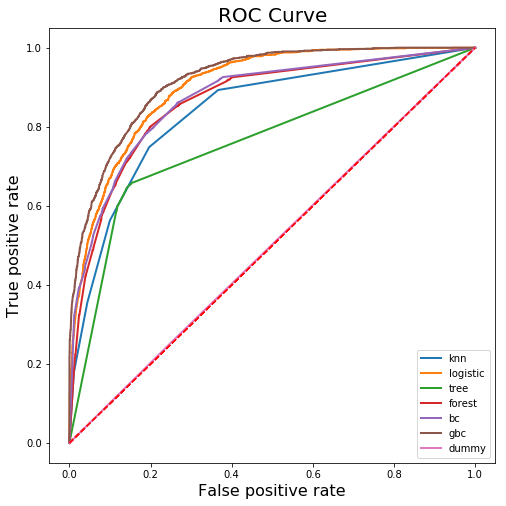

In [34]:
#  ROC w/ normalizing
for model in models:
    plt.rcParams.update({'figure.figsize': (8, 8)})
    my_model = model[1]()
    my_model.fit(X_train_trans, y_train)
    y_preds = my_model.predict_proba(X_test_fitted)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, my_model.predict_proba(X_test_fitted)[:,1])
    plt.plot(fpr, tpr,lw=2, label=model[0])
    plt.plot([0,1],[0,1],c='r',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate', fontsize=16)
    plt.ylabel('True positive rate', fontsize=16)
    plt.title('ROC Curve', fontsize=20)
    plt.legend()
    print("{}: {}".format(model[0], roc_auc_score(y_test, y_preds)))

knn: 0.8470793400313282
logistic: 0.909691056015064
tree: 0.7652343511453242
forest: 0.8829549929059999
bc: 0.8878739148727482
gbc: 0.9238185033701652
dummy: 0.4974533157847215


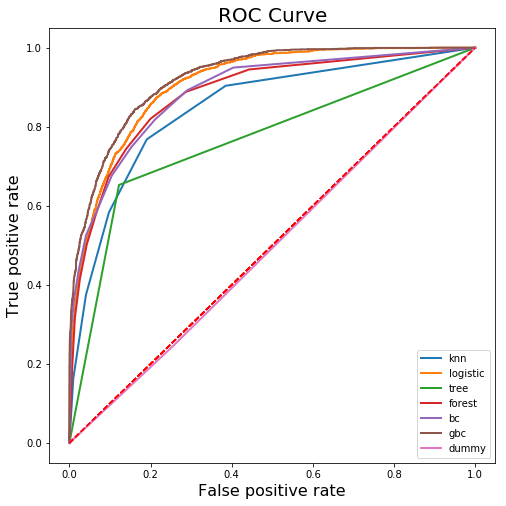

In [35]:
#  For fnlwgt - doesn't really impact modeling
#  ROC w/ normalizing
for model in models:
    plt.rcParams.update({'figure.figsize': (8, 8)})
    my_model = model[1]()
    my_model.fit(X5_train_trans, y5_train)
    y5_preds = my_model.predict_proba(X5_test_fitted)[:,1]
    fpr, tpr, thresholds = roc_curve(y5_test, my_model.predict_proba(X5_test_fitted)[:,1])
    plt.plot(fpr, tpr,lw=2, label=model[0])
    plt.plot([0,1],[0,1],c='r',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate', fontsize=16)
    plt.ylabel('True positive rate', fontsize=16)
    plt.title('ROC Curve', fontsize=20)
    plt.legend()
    print("{}: {}".format(model[0], roc_auc_score(y5_test, y5_preds)))

knn: 0.7627607237041507
logistic: 0.817923645930157
tree: 0.7377517508336903
forest: 0.7741167904323351
bc: 0.7750092538580532
gbc: 0.839321787740474
dummy: 0.5003817684759645


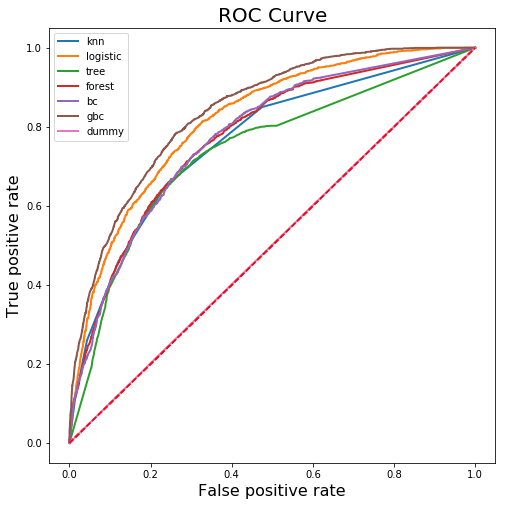

In [54]:
#  For initial hypothesis
#  ROC w/ normalizing
for model in models:
    plt.rcParams.update({'figure.figsize': (8, 8)})
    my_model = model[1]()
    my_model.fit(X2_train_trans, y2_train)
    y2_preds = my_model.predict_proba(X2_test_fitted)[:,1]
    fpr, tpr, thresholds = roc_curve(y2_test, my_model.predict_proba(X2_test_fitted)[:,1])
    plt.plot(fpr, tpr,lw=2, label=model[0])
    plt.plot([0,1],[0,1],c='r',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate', fontsize=16)
    plt.ylabel('True positive rate', fontsize=16)
    plt.title('ROC Curve', fontsize=20)
    plt.legend()
    print("{}: {}".format(model[0], roc_auc_score(y2_test, y2_preds)))

#### Let's look at the four best models w/ default parameters

In [36]:
gbt = GradientBoostingClassifier()
gbt.fit(X_train, y_train)
print("Training score: {}".format(gbt.score(X_test, y_test)))
print("Testing score: {}".format(gbt.score(X_train, y_train)))

Training score: 0.8597003049993369
Testing score: 0.8668935944476371


In [37]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Training score: {}".format(lr.score(X_test, y_test)))
print("Testing score: {}".format(lr.score(X_train, y_train)))

Training score: 0.8437872961145737
Testing score: 0.8480173290305468


In [38]:
forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)
print("Training score: {}".format(forest_model.score(X_test, y_test)))
print("Testing score: {}".format(forest_model.score(X_train, y_train)))

Training score: 0.8350351412279539
Testing score: 0.9671544140400513


In [39]:
bagging = BaggingClassifier()
bagging.fit(X_train, y_train)
print("Training score: {}".format(bagging.score(X_test, y_test)))
print("Testing score: {}".format(bagging.score(X_train, y_train)))

Training score: 0.8379525261901605
Testing score: 0.9676848945669952


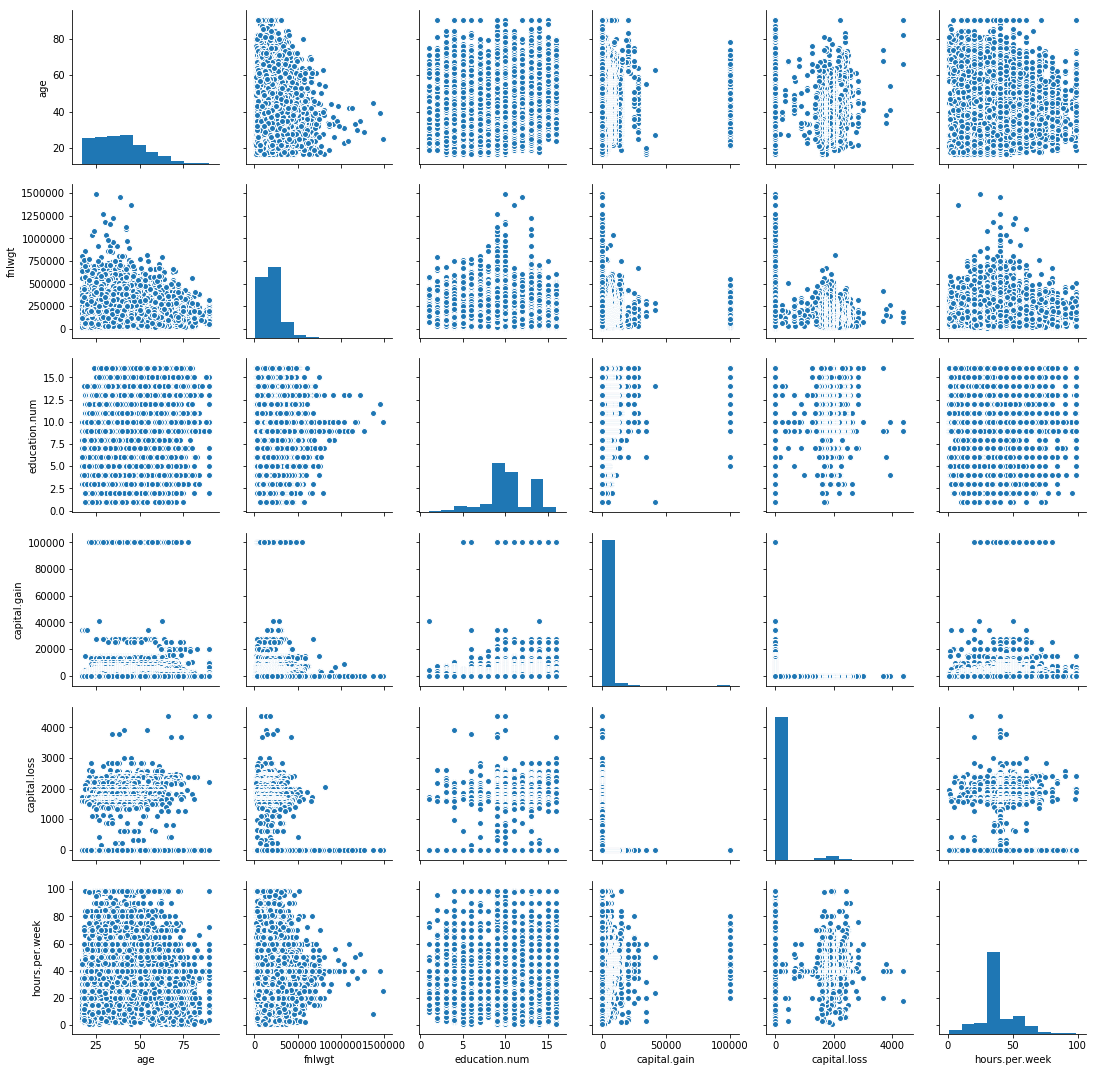

In [40]:
sns.pairplot(df)

### Feature Engineering

In [41]:
features = list(X.columns)

In [63]:
chi2_selector = SelectKBest(chi2, k=20)
X_kbest = chi2_selector.fit_transform(X, y)
Chi2_features = list(X.columns[chi2_selector.get_support()])

Chi2_indices = [features.index(f) for f in Chi2_features]
Chi2_scores_indices = [chi2_selector.scores_[k] for k in Chi2_indices]
list(zip(Chi2_features, Chi2_scores_indices))

[('age', 7927.716123549468),
 ('education.num', 2178.3061669464764),
 ('capital.gain', 74128191.75074008),
 ('capital.loss', 1256098.7520718914),
 ('hours.per.week', 5569.209087463251),
 ('workclass_Self-emp-inc', 551.1132060342126),
 ('education_Bachelors', 803.4312295207834),
 ('education_Doctorate', 496.9294809564597),
 ('education_Masters', 865.1742100656606),
 ('education_Prof-school', 725.2030747388849),
 ('marital.status_Married-civ-spouse', 3193.594240850939),
 ('marital.status_Never-married', 2093.3426860893287),
 ('occupation_Exec-managerial', 1192.2341906860026),
 ('occupation_Other-service', 742.0426906792027),
 ('occupation_Prof-specialty', 860.1898224270034),
 ('relationship_Husband', 2849.372144914881),
 ('relationship_Not-in-family', 837.9537459716288),
 ('relationship_Own-child', 1314.607729999537),
 ('relationship_Unmarried', 572.8875665357342),
 ('sex_Female', 957.0105285823246)]

In [43]:
ET = ExtraTreeClassifier()
ET.fit(X, y)    
importances = list(zip(ET.feature_importances_, X.columns))
importances.sort(reverse=True)
FI_features = [x[1] for x in importances][0:5]

FI_indices = [features.index(f) for f in FI_features]
score_indices = [ET.feature_importances_[k] for k in FI_indices]
list(zip(FI_features, score_indices))

[('age', 0.23312186673317914),
 ('hours.per.week', 0.12490264976460137),
 ('relationship_Husband', 0.09379852285611542),
 ('capital.gain', 0.06822343791434178),
 ('education.num', 0.05547711221487554)]

In [44]:
#  Recursive Feature Elimination
lm1 = LogisticRegression()
rfe = RFE(lm1, 30)
fit = rfe.fit(X, y)
RFE_features = list(X.columns[fit.support_])
RFE_features

['workclass_Without-pay',
 'education_10th',
 'education_11th',
 'education_12th',
 'education_7th-8th',
 'education_9th',
 'education_Assoc-acdm',
 'education_Assoc-voc',
 'education_Doctorate',
 'education_HS-grad',
 'education_Preschool',
 'education_Prof-school',
 'education_Some-college',
 'marital.status_Married-AF-spouse',
 'marital.status_Married-civ-spouse',
 'marital.status_Never-married',
 'occupation_Exec-managerial',
 'occupation_Farming-fishing',
 'occupation_Handlers-cleaners',
 'occupation_Other-service',
 'occupation_Priv-house-serv',
 'relationship_Other-relative',
 'relationship_Own-child',
 'relationship_Wife',
 'sex_Female',
 'native.country_Cambodia',
 'native.country_Columbia',
 'native.country_Dominican-Republic',
 'native.country_Mexico',
 'native.country_Outlying-US(Guam-USVI-etc)']

In [45]:
pca = PCA(n_components=5)
fit = pca.fit(X)    
df = pd.DataFrame(pca.components_,columns=X.columns).abs().mean().sort_values(ascending = False)
PCA_features = list(df.index.values)[0:7]
PCA_features

['hours.per.week',
 'age',
 'education.num',
 'capital.loss',
 'capital.gain',
 'education_Bachelors',
 'education_HS-grad']